# Customer Segmentation using Clustering
***
This mini-project is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by yhat. Please feel free to refer to the post for additional information, and solutions.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## Data

The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## Data wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [4]:
# check to make sure that all offer ids are valid in the original data
df_offers.offer_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [5]:
df = pd.merge(df_offers, df_transactions)

In [6]:
pivot = df.pivot_table(index=['customer_name'], columns=['offer_id'], values='n')

In [7]:
#fill all 'NaN' values with 0
pivot = pivot.fillna(0).reset_index()

In [8]:
pivot.index.rename('index', inplace=True)

## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

#### What values of  𝑆𝑆  do you believe represent better clusterings? Why?
$SS$ measures the compactness (i.e goodness) of the clustering and we want it to be as small as possible. As we increase the number of clusters we are grouping less observations together. Since we are looking to find similarities is the observations we want to find a small number of clusters that retains a low $SS$ value.

In [9]:
 x_cols = pivot.iloc[:,1::].values

In [10]:
print(type(x_cols))

<class 'numpy.ndarray'>


In [11]:
# setup a range of possible k values; 2 <= k <= 10
k_range = list(range(2,11))
ss_values = []


from sklearn.cluster import KMeans

#Cycle through the possible number of clusters recording the sum-of-squares for each solution
for i in k_range:
    km = KMeans(n_clusters=i, random_state=1, init='k-means++')
    km.fit(x_cols)
    labels = km.labels_
    ss_values.append(km.inertia_)
    

(160, 260)

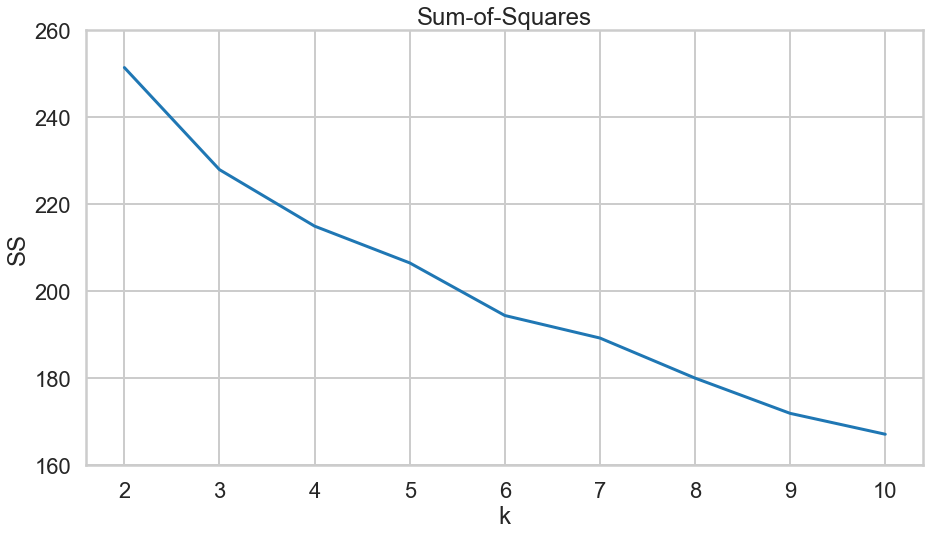

In [12]:
#plot the sum-of-squares to find the elbow
plt.figure(figsize=(15,8))
sns.lineplot(k_range,ss_values)
plt.xlabel('k')
plt.ylabel('SS')
plt.title('Sum-of-Squares')
plt.ylim(160, 260)


In [13]:
# count membership using k = 6 (where the largest elbow is)
# extract counts of cluster membership
k = 6
km = KMeans(n_clusters=i, random_state=1, init='k-means++')
pivot['cluster'] = km.fit_predict(x_cols)

Text(0.5, 1.0, 'Cluster Membership \n K=8')

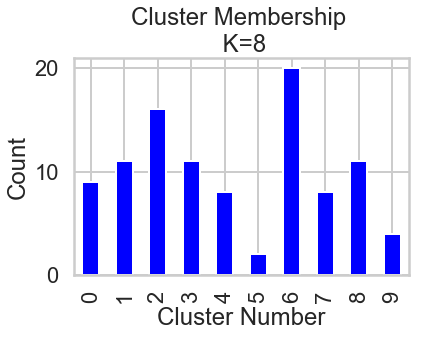

In [14]:
pivot.cluster.value_counts().sort_index().plot(kind='bar', color='blue')
plt.xlabel('Cluster Number')
plt.ylabel('Count')
plt.title("Cluster Membership \n K=8")

#### What challenges did you experience using the Elbow method to pick  𝐾 ?
The main challenge in using the elbow method in this data set is that there is not a clear critial point (i.e. elbow) on the graph. This indicates that the clusters are not clearly defined which makes the ideal number of clusters difficult to find.

### Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

Fortunately, scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

Text(0, 0.5, 'Silhouette Score')

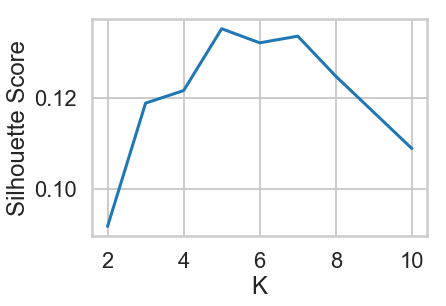

In [15]:
#Calculate the average silhouette score for the number of clusters in the range of 2 <= k <= 10
from sklearn.metrics import silhouette_score, silhouette_samples

silh_score = []

for i in k_range:
    km = KMeans(n_clusters=i, random_state=1)
    km.fit(x_cols)
    labels = km.labels_
    silh_score.append(silhouette_score(x_cols, labels))
    
sns.lineplot(k_range, silh_score)
plt.xlabel('K')
plt.ylabel('Silhouette Score')

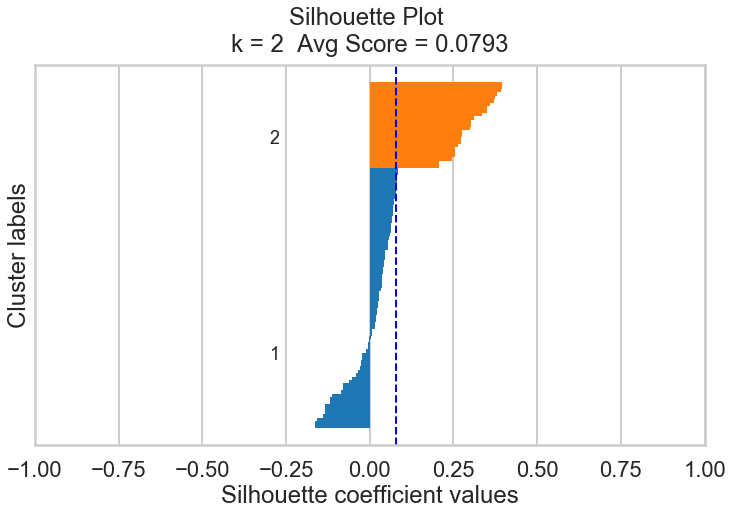

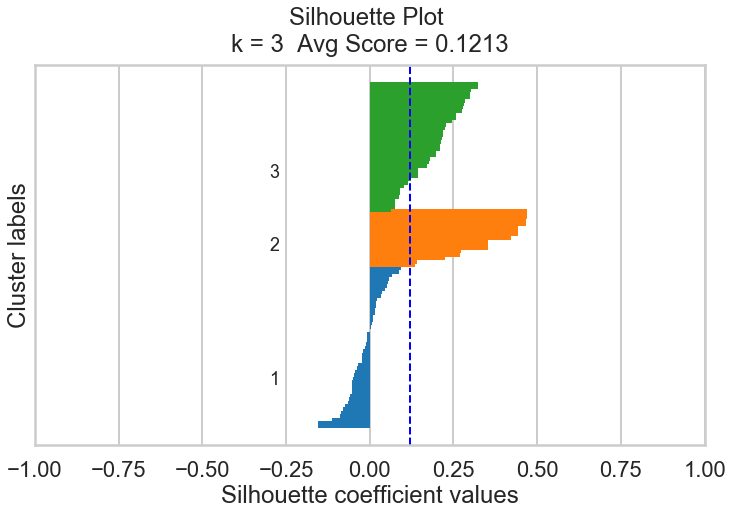

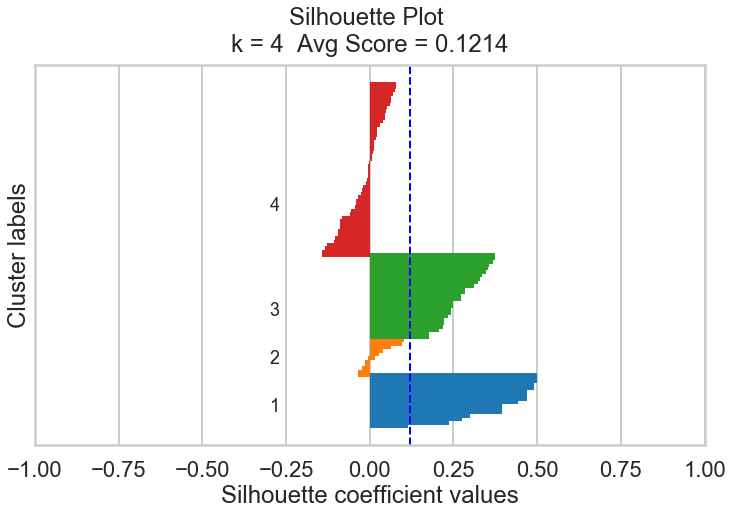

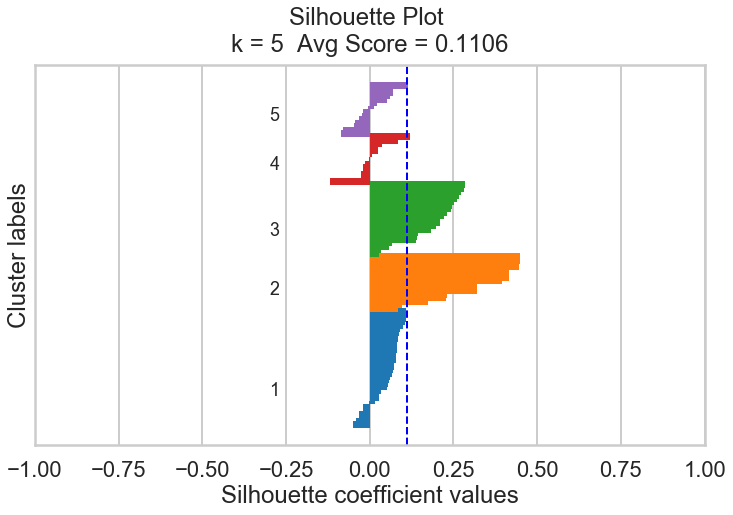

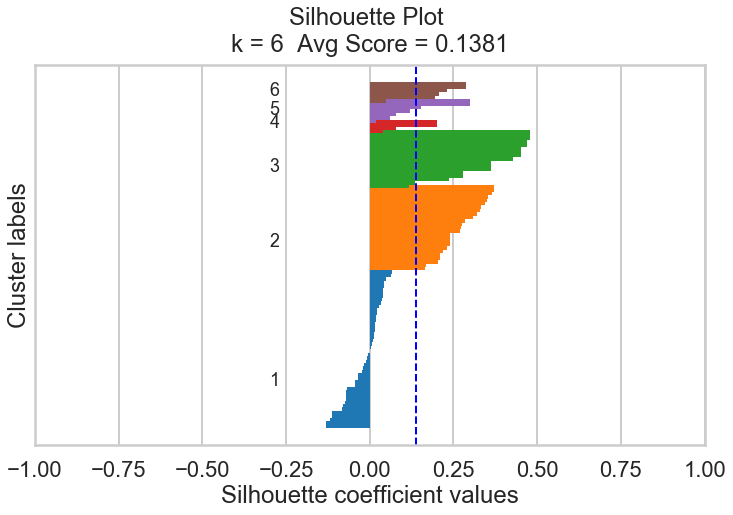

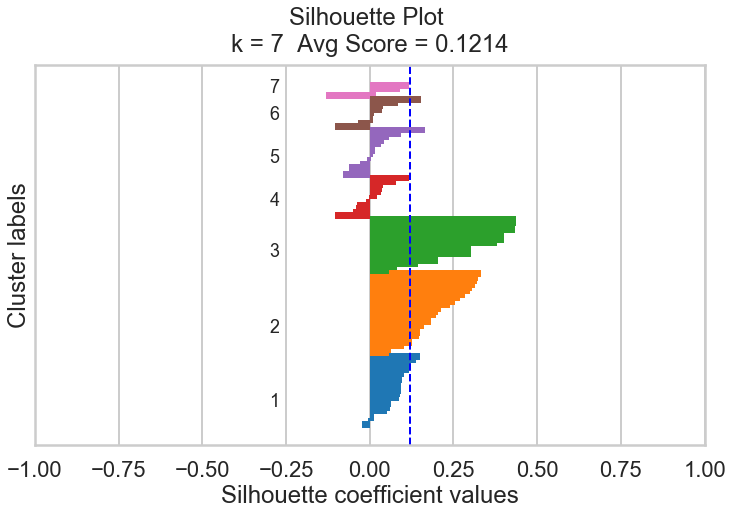

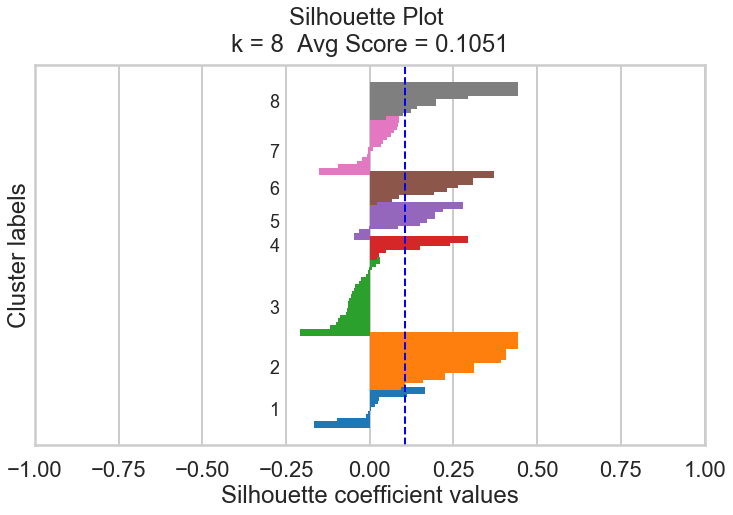

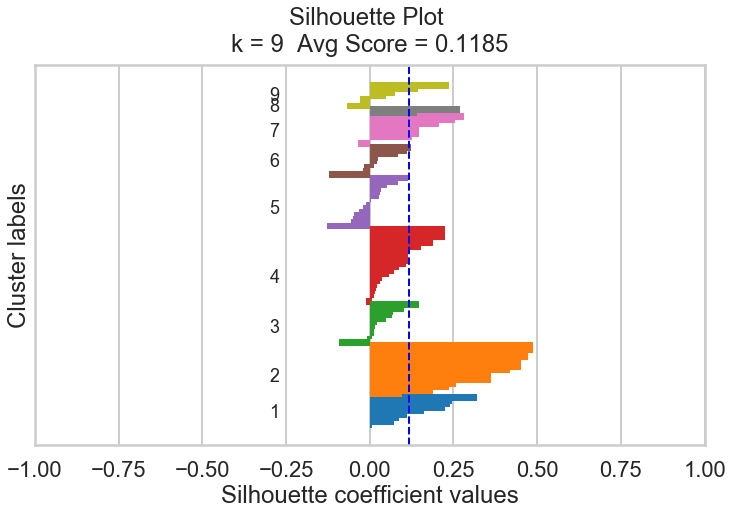

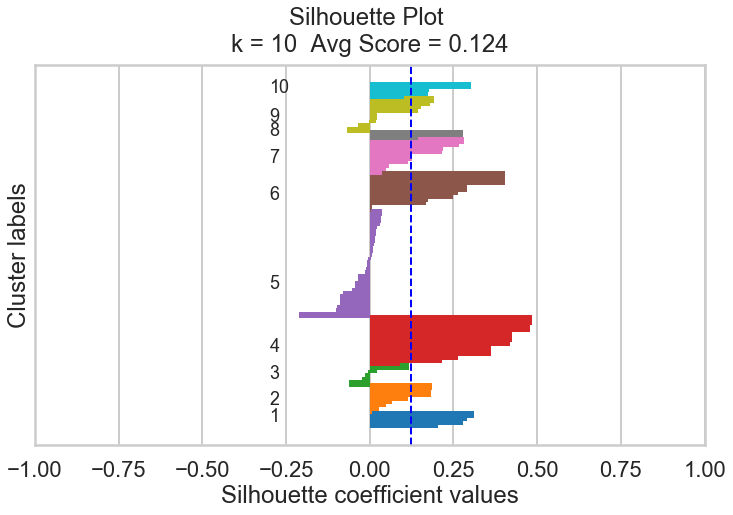

In [16]:
# Display detailed silhouette score information for each number of clusters
for i, k in enumerate(range(2,11)):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(12, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(x_cols)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(x_cols, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        cluster_size = cluster_silhouette_vals.shape[0]
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=2)
        ax1.text(-0.3, y_lower + 0.25 * cluster_size, str(i + 1), fontsize=18)
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='blue')
    ax1.set_yticks([])
    ax1.set_xlim([-1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette Plot \nk = ' + str(k) + '  Avg Score = ' + str(round(avg_score, 4)), y=1.02);
    

#### What  𝐾  does the plot suggest we should choose? 
The silhouette plots paired with the average score suggest a cluster size of 5 should be used. Though the structure of the clusters are fairly weak. This is one less cluster than what the elbow graph indicated as the best number of clusters.

### Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

In [36]:
from sklearn.decomposition import PCA

# run the PCA with 2 components
pca = PCA(n_components = 2)
wine_factors = np.matrix(pca.fit_transform(x_cols))
wine_factors_df = pd.DataFrame(wine_factors)
wine_factors_df.columns = ['x','y']

# initialize dataset with names and factors
wine_clusters = pd.DataFrame(pivot.iloc[:,0])
wine_clusters['x'], wine_clusters['y'] = wine_factors_df['x'], wine_factors_df['y']

# add cluster labels using the same k-range as used above
for k in k_range:
    
    # calculate cluster labels
    clusterer = KMeans(n_clusters= k, random_state=1)
    cluster_labels = clusterer.fit_predict(wine_factors)
    
    # append labels to dataframe
    wine_clusters[str('clusters_' + str(k))] = cluster_labels

wine_clusters.head()

,customer_name,x,y,clusters_2,clusters_3,clusters_4,clusters_5,clusters_6,clusters_7,clusters_8,clusters_9,clusters_10
index,,,,,,,,,,,,
0,Adams,1.007580,0.108215,1,0,0,4,4,6,4,0,0
1,Allen,-0.287539,0.044715,0,1,1,0,1,4,3,4,9
2,Anderson,-0.392032,1.038391,0,2,2,2,3,3,2,5,5
3,Bailey,0.699477,-0.022542,1,0,0,1,2,1,7,3,3
4,Baker,0.088183,-0.471695,0,1,1,3,0,2,0,1,1


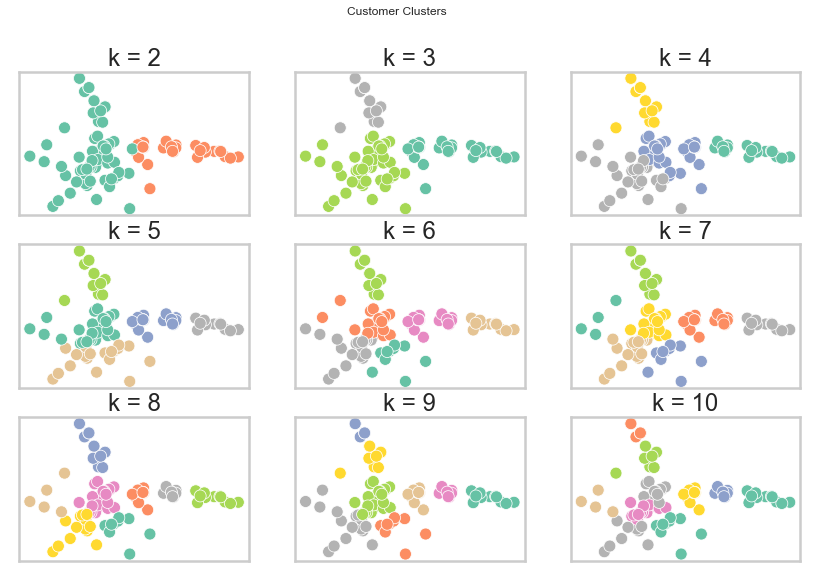

In [37]:
# setup figure and fill with data
fig = plt.figure(figsize=(14, 9))
fig.suptitle('Customer Clusters')

for k in k_range:    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # fill data in the scatterplots
    sns.scatterplot(x = wine_clusters['x'], y = wine_clusters['y'], hue=wine_clusters.iloc[:,k + 1],
                    palette="Set2", legend=None)
    ax.set_title('k = ' + str(k))

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

#### How do the clusters look?
Based on the scatterplots, I would recommend using K = 3. With K = 3 we see no overlap and that the clusters have clear a reasonable amount of structure.

Text(0.5, 1.0, 'Explained Variance vs. Components')

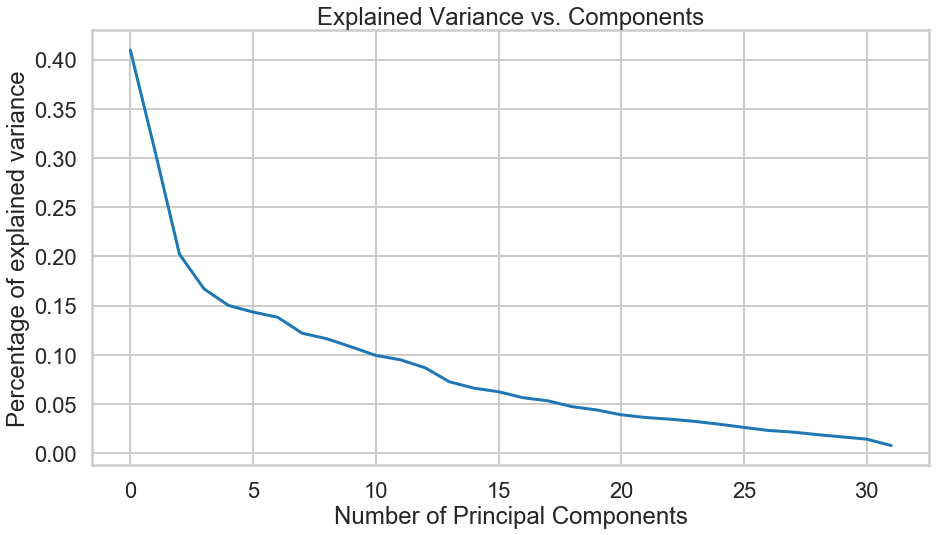

In [20]:
pca = PCA()
factors = pca.fit(x_cols)

# elbow curve

plt.figure(figsize=(15,8))
sns.lineplot(range(0,len(factors.explained_variance_)), factors.explained_variance_)
    
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage of explained variance')
plt.title('Explained Variance vs. Components')

#### This value is one possible value for the optimal number of dimensions. What is it?

The explained variance plot has a more defined "elbow" (4 principal componenents). 

## Other Clustering Algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

In [ ]:
cluster = sklearn.cluster.AffinityPropagation( damping = 0.75)
cluster_labels = cluster.fit_predict(x_cols)

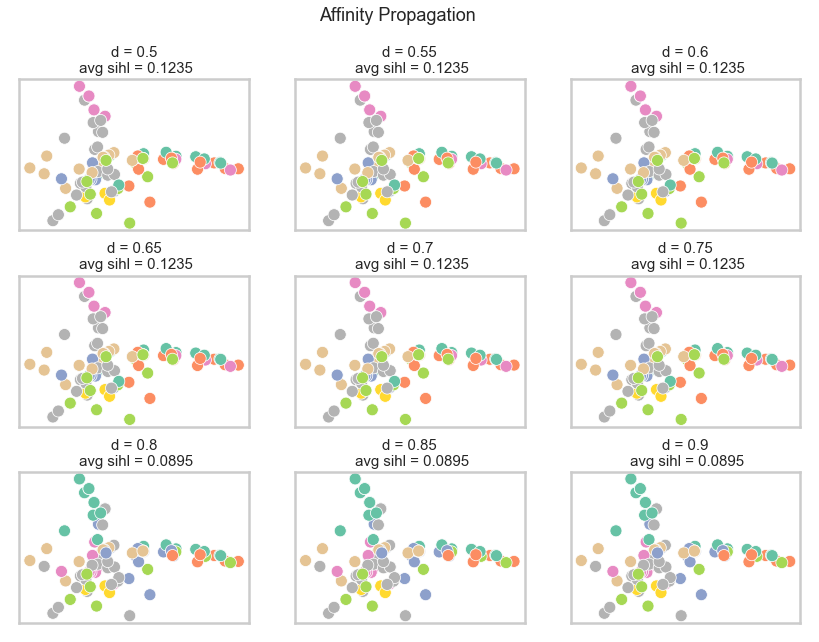

In [30]:
from sklearn.cluster import AffinityPropagation 

# since Affinity propagation allows for selecting damping, I will explore a range of dampings 
# which controls the learning rate of the algorithm.
damp_range = np.arange(0.5,0.95,0.05)

fig = plt.figure(figsize=(14, 10))
fig.suptitle('Affinity Propagation', fontsize=18)
plt.subplots_adjust(hspace = 0.3 )

count =1

for d in damp_range:    
    cluster = sklearn.cluster.AffinityPropagation( damping = d )
    cluster_labels = cluster.fit_predict(x_cols)
    
    # setup plots and axes
    ax = fig.add_subplot(3,3,count)
    ax.set_xticks([])
    ax.set_yticks([])
    count +=1
    
    sns.scatterplot(x = wine_clusters['x'], y = wine_clusters['y'], hue = cluster_labels,
                    palette="Set2", legend=None)
    plt.title('d = ' + str(round(d,2))+ "\n avg sihl = " + str(round(silhouette_score(x_cols,cluster_labels),4)), fontsize=15)

When testing a range of damping factors in the affinity propagation algorithm on this data I find that lower learning rates result in a higher silhouete score. However a visual examination of the data indicates that the solution overfits the data on all accounts.

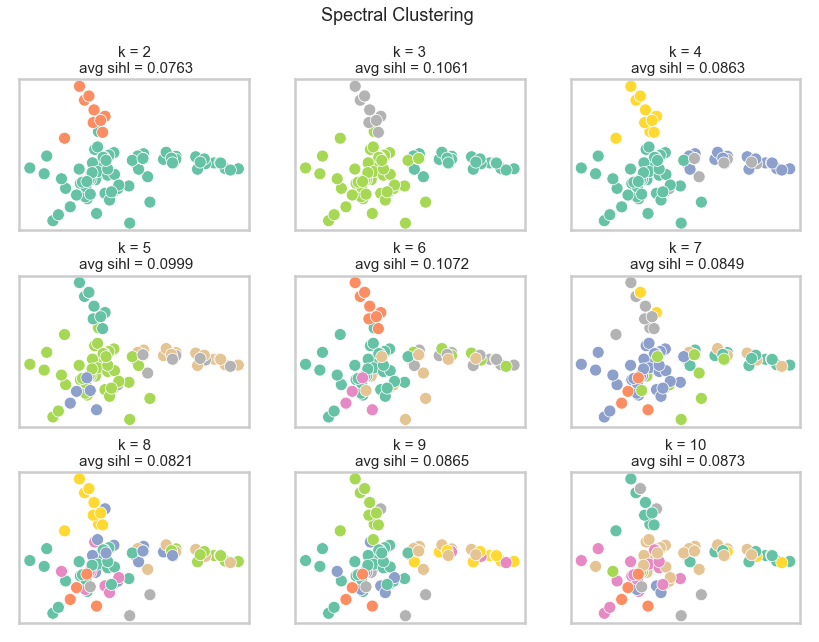

In [24]:
from sklearn.cluster import SpectralClustering

fig = plt.figure(figsize=(14, 10))
fig.suptitle('Spectral Clustering', fontsize=18)
plt.subplots_adjust(hspace = 0.3 )

for k in k_range:    
    cluster = sklearn.cluster.SpectralClustering( n_clusters = k, random_state = 1 )
    cluster_labels = cluster.fit_predict(x_cols)
    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    sns.scatterplot(x = wine_clusters['x'], y = wine_clusters['y'], hue = cluster_labels,
                    palette="Set2", legend=None)
    plt.title('k = ' + str(k)+ "\n avg sihl = " + str(round(silhouette_score(x_cols,cluster_labels),4)), fontsize=15)

When using spectral clustering on the wine dataset a sweep on the number of clusters shows that k=3 and k=6 have similar silhoutte scores. Upon visual examination it is clear that k=3 is the better choice because the clusters are more clearly defined and lack significant overlap. This is inline with what was seen using the K-means clustering algorithm, but spectral clustering has more overlap then k-means.

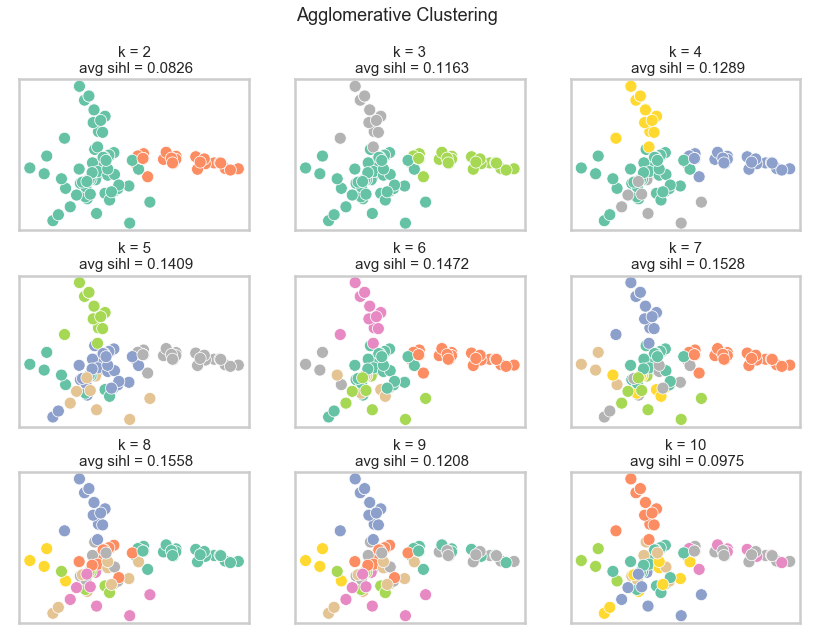

In [26]:
from sklearn.cluster import AgglomerativeClustering

fig = plt.figure(figsize=(14, 10))
fig.suptitle('Agglomerative Clustering', fontsize=18)
plt.subplots_adjust(hspace = 0.3 )

for k in k_range:    
    cluster = sklearn.cluster.AgglomerativeClustering( n_clusters = k)
    cluster_labels = cluster.fit_predict(x_cols)
    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k-1)
    ax.set_xticks([])
    ax.set_yticks([])
    
    sns.scatterplot(x = wine_clusters['x'], y = wine_clusters['y'], hue = cluster_labels,
                    palette="Set2", legend=None)
    plt.title('k = ' + str(k)+ "\n avg sihl = " + str(round(silhouette_score(x_cols,cluster_labels),4)), fontsize=15)

Agglomerative clustering has an elbow point at k=3. This is inline with what was seen using the K-means clustering algorithm, but spectral clustering has more overlap then k-means.

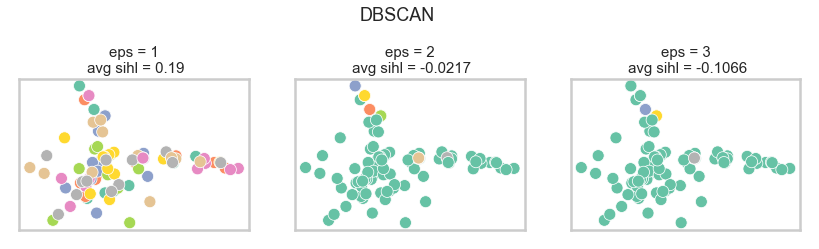

In [35]:
from sklearn.cluster import DBSCAN

fig = plt.figure(figsize=(14, 10))
fig.suptitle('DBSCAN', fontsize=18)
plt.subplots_adjust(hspace = 0.3 )

for k in [1, 2, 3]:
    db=DBSCAN(eps=.001, min_samples=k)
    db.fit(x_cols)
    
    # setup plots and axes
    ax = fig.add_subplot(3,3,k)
    ax.set_xticks([])
    ax.set_yticks([])
    
    sns.scatterplot(x = wine_clusters['x'], y = wine_clusters['y'], hue = db.labels_,
                    palette="Set2", legend=None)
    plt.title('eps = ' + str(k)+ "\n avg silh = " + str(round(silhouette_score(x_cols,db.labels_),4)), fontsize=15)

DBSCAN uses a different approach to clustering. Given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors). Other points either form different neighborhoods or are outliers. In this dataset he points are so close together that the only positive average silhouette score when the neighborhood is 1, which results in a large overlap. DBSCAN is not a good candidate for clustering this dataset.

## Concluding Remarks

The dataset presented allows for the exploration of customer buying behavior when presented with a series of 32 promotional offers. There are not drastic difference in customer response patterns as evidence by the number of ideal clusters not being easily identified. This can be attributed to the fact that wine is good that consumers tend to consume wine in modernation on most days. It would be interesting to continue to explore the dataset to find what factors of the offers contribute most (i.e. time of year, wine's country of origin or the wine's age) to if a consumer buying behavoir.

However, there are three consumer buying trends (i.e. clusters) that emerge in the anaylsis performed to this point. 
